# Imports

In [1]:
import pandas as pd
from xgboost import XGBClassifier as xgbc
# Sklearn tools
import sklearn
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.inspection import permutation_importance
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import scikeras
import tensorflow as tf
import keras


#tensor flow
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Sklearn wrapper
from scikeras.wrappers import KerasClassifier

#Other
import numpy as np

# Download Data

In [2]:
df = pd.read_csv("data/train.csv")

df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


# Data Preprocessing

In [3]:
# Drop irrelevant columns
columns_to_drop = ['PassengerId', 'Name']
df.drop(columns_to_drop, axis=1, inplace=True)

# Split the 'Cabin' column into 'Deck', 'CabinNumber', and 'Side'
df['Deck'] = df['Cabin'].str.extract(r'([A-Za-z])')  # Extract the first letter (Deck)
df['CabinNumber'] = df['Cabin'].str.extract(r'(\d+)')  # Extract the digits (Cabin number)
df['Side'] = df['Cabin'].str.extract(r'([PS])')  # Extract the side ('P' for Port, 'S' for Starboard)

# Drop the original 'Cabin' column after the split
df.drop('Cabin', axis=1, inplace=True)

# Combine all the spending features into a single total spend feature
spend_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df[spend_cols] = df[spend_cols].fillna(0)  # Fill missing spending data with 0
df['TotalSpend'] = df[spend_cols].sum(axis=1)  # Create TotalSpend as the sum of all spending features

# Fill missing values for each of the extracted features
df['Deck'] = df['Deck'].fillna('None')
df['CabinNumber'] = df['CabinNumber'].fillna('None')
df['Side'] = df['Side'].fillna('None')

# Fill missing boolean values (CryoSleep) with false if spenditure was 0
df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpend'] == 0).astype(bool)

# Filter the DataFrame to get the rows where VIP is True
vip_df = df[df['VIP'] == True]

# Calculate the average spending of VIPs
avg_vip_spend = vip_df['TotalSpend'].mean()

# Use this average to set the spending threshold
# Fill missing VIP values based on whether TotalSpend exceeds the average VIP spend
df['VIP'] = df['VIP'].fillna(df['TotalSpend'] > avg_vip_spend)

# Fill missing numerical values for 'Age' with the median
df['Age'] = df['Age'].fillna(df['Age'].median())

# Fill missing categorical values for 'HomePlanet' and 'Destination' with the most common value (mode)
df['HomePlanet'] = df['HomePlanet'].fillna(df['HomePlanet'].mode()[0])
df['Destination'] = df['Destination'].fillna(df['Destination'].mode()[0])

# Encode HomePlanet
le_homeplanet = LabelEncoder()
df['HomePlanet'] = le_homeplanet.fit_transform(df['HomePlanet'].astype(str))

# Encode Destination
le_destination = LabelEncoder()
df['Destination'] = le_destination.fit_transform(df['Destination'].astype(str))

# Encode Deck
le_deck = LabelEncoder()
df['Deck'] = le_deck.fit_transform(df['Deck'].astype(str))

# Encode CabinNumber
le_cabinnumber = LabelEncoder()
df['CabinNumber'] = le_cabinnumber.fit_transform(df['CabinNumber'].astype(str))

# Encode Side
le_side = LabelEncoder()
df['Side'] = le_side.fit_transform(df['Side'].astype(str))

# Convert CryoSleep and VIP to int
df['CryoSleep'] = df['CryoSleep'].astype(int)
df['VIP'] = df['VIP'].astype(int)

# Encode Transported
le_transported = LabelEncoder()
df['Transported'] = le_transported.fit_transform(df['Transported'].astype(str))

df.drop('TotalSpend', axis=1, inplace=True)

df.head()

C:\Users\Santiago\AppData\Local\Temp\ipykernel_15984\211715771.py:24: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['CryoSleep'] = df['CryoSleep'].fillna(df['TotalSpend'] == 0).astype(bool)
C:\Users\Santiago\AppData\Local\Temp\ipykernel_15984\211715771.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['VIP'] = df['VIP'].fillna(df['TotalSpend'] > avg_vip_spend)


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Deck,CabinNumber,Side
0,1,0,2,39.0,0,0.0,0.0,0.0,0.0,0.0,0,1,0,1
1,0,0,2,24.0,0,109.0,9.0,25.0,549.0,44.0,1,5,0,2
2,1,0,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,0,0,0,2
3,1,0,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,0,0,0,2
4,0,0,2,16.0,0,303.0,70.0,151.0,565.0,2.0,1,5,1,2


# Splitting the dataset

In [4]:
# Define features (X) and target (y)
X = df.drop('Transported', axis=1)  # All columns except 'Transported' are features
y = df['Transported']  # 'Transported' is the target variable

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

# Check the shape of the resulting datasets
print(f'Training set size: {X_train.shape}')
print(f'Testing set size: {X_test.shape}')

Training set size: (6954, 13)
Testing set size: (1739, 13)


# Random Forest

In [5]:
my_RandomForest = rfc(n_estimators=30, bootstrap=True, random_state=2)
my_RandomForest.fit(X_train, y_train)

rfc_predict = my_RandomForest.predict(X_test)
rfc_prob = my_RandomForest.predict_proba(X_test)[:, 1]

accuracy_rf = accuracy_score(y_test, rfc_predict)
auc_rf = roc_auc_score(y_test, rfc_prob)

print(f"AUC of Random Forest: {auc_rf:.4f}")
print(f"Accuracy of Random Forest: {accuracy_rf:.4f}")

AUC of Random Forest: 0.8698
Accuracy of Random Forest: 0.7941


In [6]:
importances = my_RandomForest.feature_importances_

feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(20))

         Feature  Importance
11   CabinNumber    0.182356
3            Age    0.130871
8            Spa    0.119178
6      FoodCourt    0.099532
9         VRDeck    0.097491
5    RoomService    0.096664
7   ShoppingMall    0.079996
1      CryoSleep    0.059954
10          Deck    0.058854
0     HomePlanet    0.031462
12          Side    0.020813
2    Destination    0.020545
4            VIP    0.002284


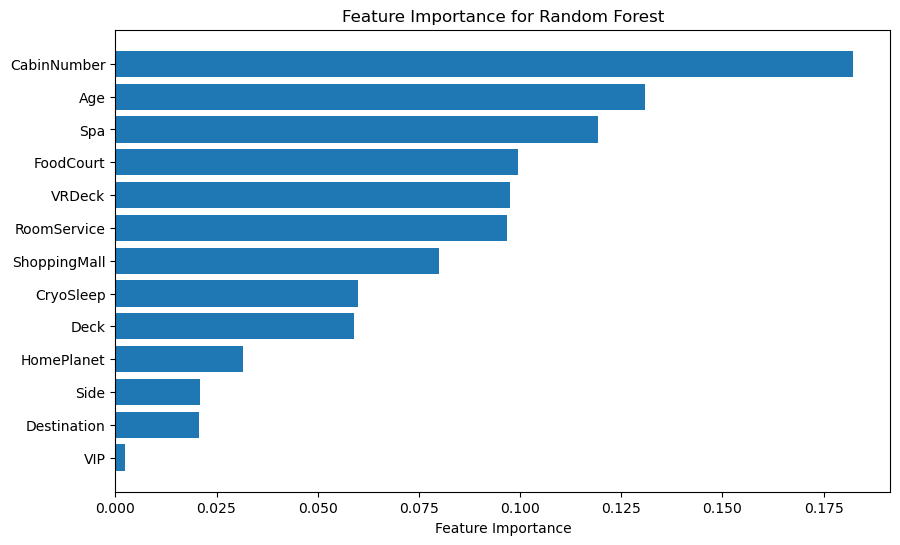

In [7]:
# Plotting feature importance for Random Forest
importances = my_RandomForest.feature_importances_

# Sort the feature importances in descending order
indices = importances.argsort()

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance for Random Forest")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
plt.xlabel("Feature Importance")
plt.show()

# XGBoost

In [8]:
# Initialize the XGBoost classifier
my_XGBoost = xgbc(n_estimators = 30,random_state=2)

# Train the XGBoost model using the training data
my_XGBoost.fit(X_train, y_train)

# Make predictions on the test dataset (class labels: 0 or 1)
xgb_preds = my_XGBoost.predict(X_test)

# Get predicted probabilities for the positive class (malignant cancer)
xgb_probs = my_XGBoost.predict_proba(X_test)[:, 1]

# Calculate the accuracy of the xgb
xgb_accuracy = accuracy_score(y_test, xgb_preds)

auc_xgb = roc_auc_score(y_test, xgb_probs)

# Print accuracy and AUC score to evaluate XGBoost's performance
print(f"XGBoost AUC: {auc_xgb:.4f}")
print(F"XGBoost Accuracy: {xgb_accuracy:.4f}")

XGBoost AUC: 0.8867
XGBoost Accuracy: 0.7959


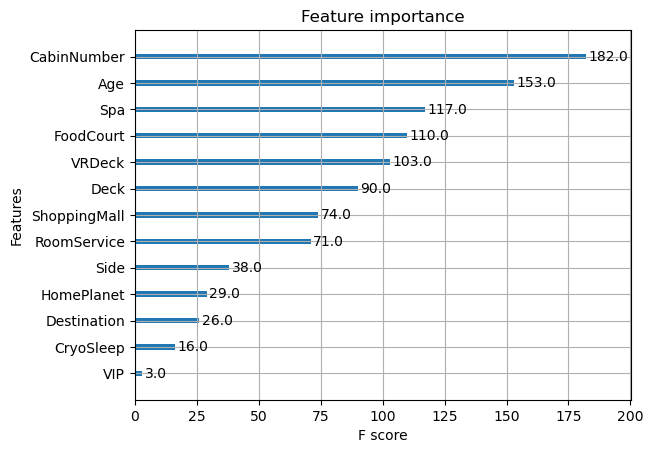

In [9]:
from xgboost import plot_importance

# Plot feature importance
plot_importance(my_XGBoost)
plt.show()

# Ann Model

In [10]:
# Create the model
def model_creator():
    model = Sequential()
    input_size = 13
    hidden_neurons = 100
    out_size = 1

    ## Designing the ANN Structure (with 13 inputs, 1 output and 100 neurons in a hidden layer):

    # second layer: hidden layer
    model.add(Dense(hidden_neurons, input_dim=input_size))  # Neurons
    model.add(Activation('relu'))  # Activation

    # third layer: output layer
    model.add(Dense(out_size))  # No need to specify input_dim again here
    model.add(Activation('sigmoid'))  # Activation

    # compile
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # return
    return model

# Train model
my_Ann = model_creator()
fitted_my_Ann = my_Ann.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)

C:\Users\Santiago\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6919 - loss: 16.2667 - val_accuracy: 0.7217 - val_loss: 3.5829
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7087 - loss: 3.2589 - val_accuracy: 0.7631 - val_loss: 2.5804
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7366 - loss: 2.6680 - val_accuracy: 0.7021 - val_loss: 1.7990
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7306 - loss: 1.8611 - val_accuracy: 0.7545 - val_loss: 2.3932
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7367 - loss: 1.8731 - val_accuracy: 0.7240 - val_loss: 1.9263
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7262 - loss: 1.8099 - val_accuracy: 0.6929 - val_loss: 1.7028
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7371 - loss: 1.8392 - val_accuracy: 0.7631 - val_loss: 1.6786
Epoch 8/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7448 - loss: 1.4612 - val_accuracy: 0

In [47]:
# Get predictions (probabilities)
ann_probs =  my_Ann.predict(X_test, verbose=2)

ann_loss, ann_acc = my_Ann.evaluate(X_test, y_test, verbose=1)
ann_auc = roc_auc_score(y_test, ann_probs)

print(f'The Loss is: {ann_loss:.4f}')
print(f'The Accuracy is: {ann_acc:.4f}')
print(f'The AUC is: {ann_auc:.4f}')

55/55 - 0s - 984us/step
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.7421 - loss: 1.5721
The Loss is: 1.4048
The Accuracy is: 0.7573
The AUC is: 0.8338


In [48]:
my_Ann.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 100)                 │           1,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,505 (17.60 KB)

 Trainable params: 1,501 (5.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,004 (11.74 KB)

# ADA Boost

In [49]:
# Create and train the Adaboost model
my_adaboost = AdaBoostClassifier(n_estimators=30, random_state=2, algorithm='SAMME')  # Adjust n_estimators and random_state as needed
# Train on a single feature using imputed data
my_adaboost.fit(X_train, y_train)

# Evaluate the model
# Predict and evaluate
ada_pred = my_adaboost.predict(X_test)
ada_probs = my_adaboost.predict_proba(X_test)[:, 1]  # Predict probabilities for class 1 (positive class)

ada_accuracy = accuracy_score(y_test, ada_pred)
ada_auc = roc_auc_score(y_test, ada_probs)

print(f'Adaboost Accuracy: {ada_accuracy:.4f}')
print(f'Adaboost AUC: {ada_auc:.4f}')

Adaboost Accuracy: 0.7677
Adaboost AUC: 0.8447


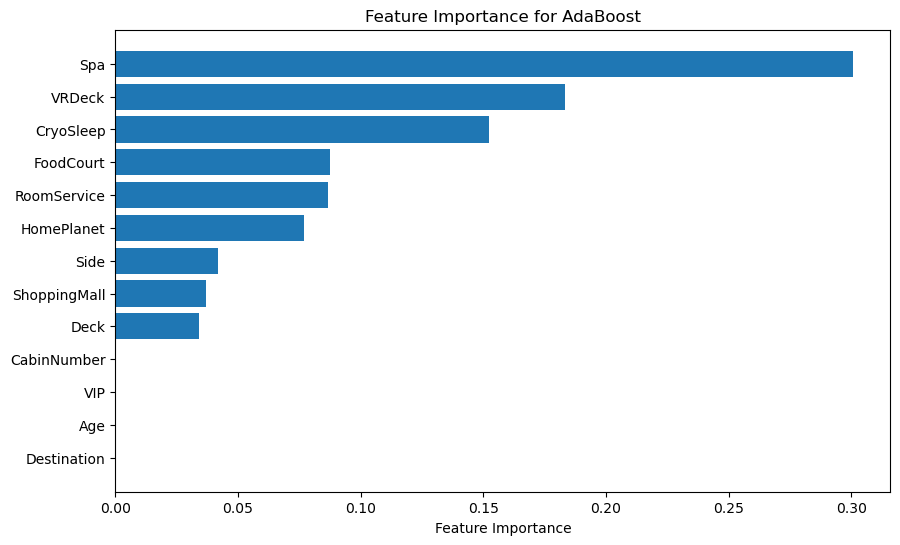

In [15]:
# Get feature importances from the AdaBoost model
importances = my_adaboost.feature_importances_

# Sort the feature importances
indices = np.argsort(importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importance for AdaBoost")
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])  # Use feature names on the y-axis
plt.xlabel("Feature Importance")
plt.show()

# Comparison

In [40]:
# Store the accuracy scores
accuracy_scores = []
auc_scores = []

models = {
    'Random Forest': my_RandomForest,
    'XGBoost': my_XGBoost,
    'Ann': my_Ann,
    'AdaBoost': my_adaboost
}

accuracy_scores.append(accuracy_rf)
accuracy_scores.append(xgb_accuracy)
accuracy_scores.append(ann_acc)
accuracy_scores.append(ada_accuracy)

auc_scores.append(auc_rf)
auc_scores.append(auc_xgb)
auc_scores.append(ann_auc)
auc_scores.append(ada_auc)

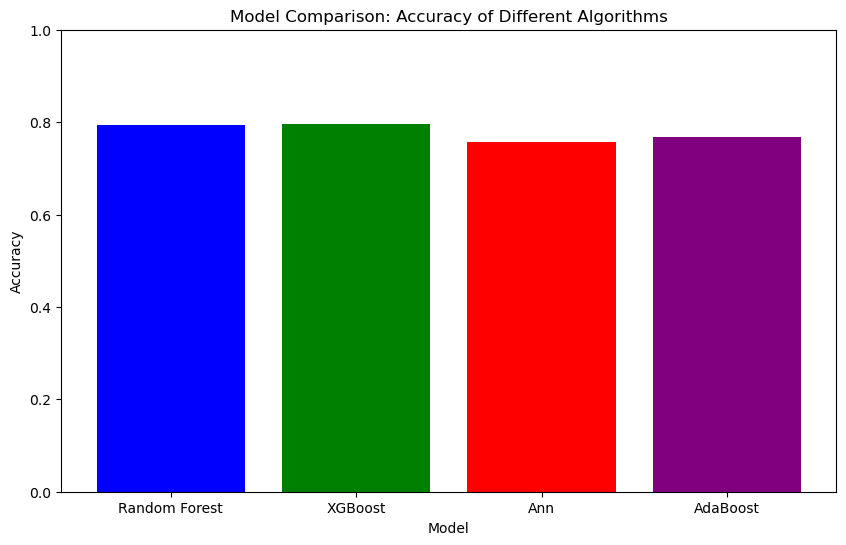

In [41]:
# Create a bar plot to compare the accuracy of models
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), accuracy_scores, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy of Different Algorithms')
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.show()

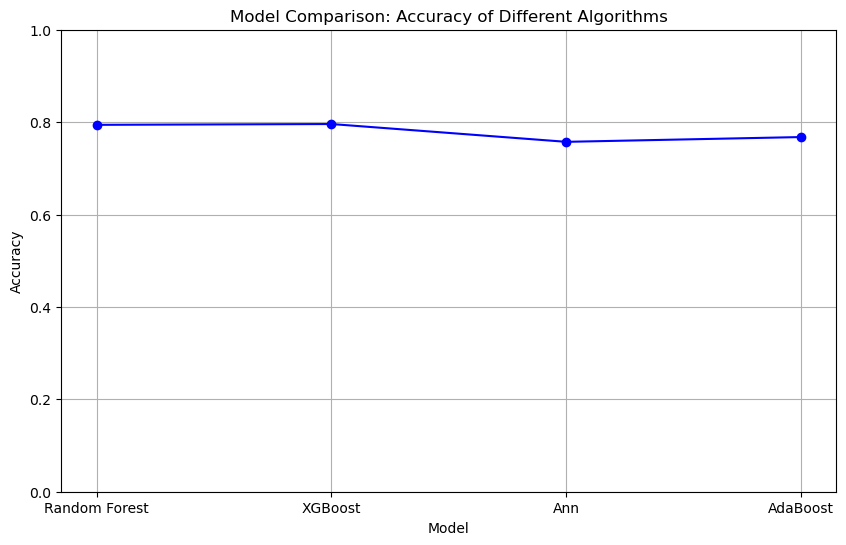

In [42]:
# Create a line plot to compare the accuracy of models
plt.figure(figsize=(10, 6))
plt.plot(models.keys(), accuracy_scores, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy of Different Algorithms')
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.grid(True)
plt.show()

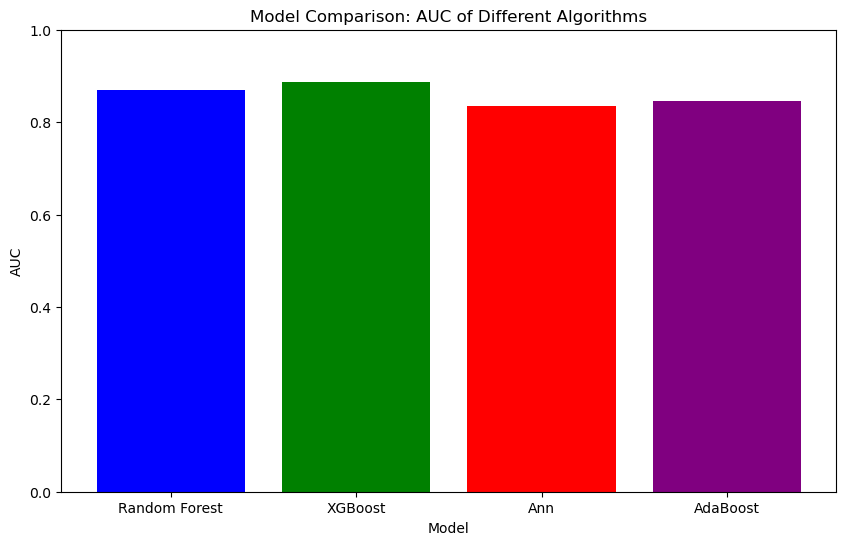

In [43]:
# Create a bar plot to compare the accuracy of models
plt.figure(figsize=(10, 6))
plt.bar(models.keys(), auc_scores, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.xlabel('Model')
plt.ylabel('AUC')
plt.title('Model Comparison: AUC of Different Algorithms')
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.show()

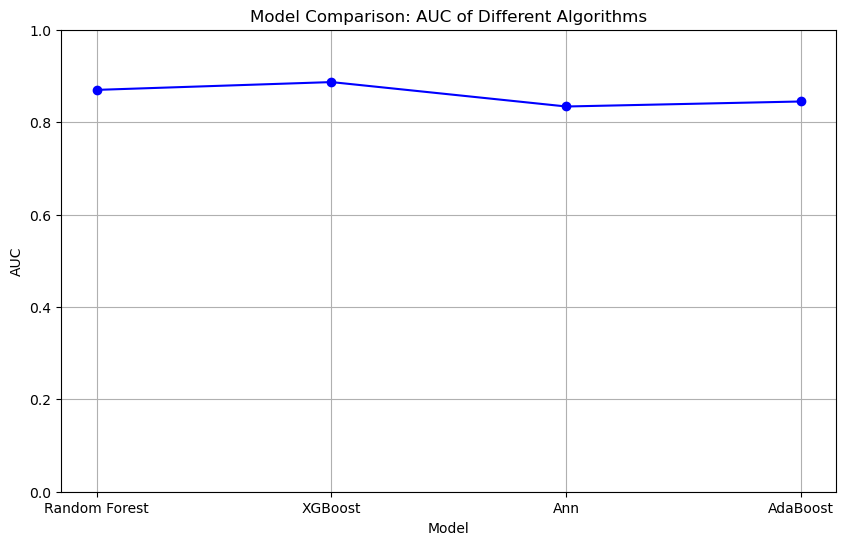

In [44]:
# Create a line plot to compare the accuracy of models
plt.figure(figsize=(10, 6))
plt.plot(models.keys(), auc_scores, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Model')
plt.ylabel('AUC')
plt.title('Model Comparison: AUC of Different Algorithms')
plt.ylim(0, 1)  # Accuracy range from 0 to 1
plt.grid(True)
plt.show()

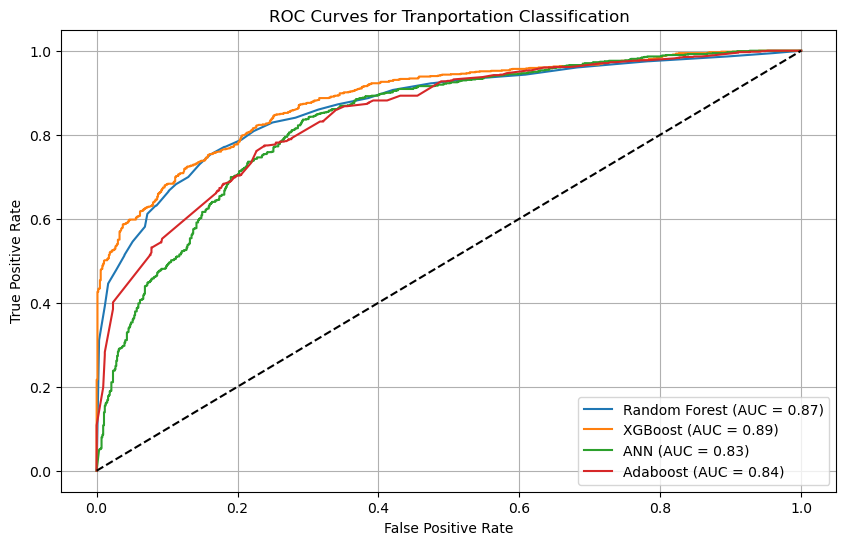

In [51]:
%matplotlib inline

plt.figure(figsize=(10, 6))

# Function to plot the ROC curve
def plot_roc_curve(y_test, probs, label):
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc_score(y_test, probs):.2f})")

# Plot ROC curves for Random Forest and XGBoost
plot_roc_curve(y_test, rfc_prob, "Random Forest")
plot_roc_curve(y_test, xgb_probs, "XGBoost")
plot_roc_curve(y_test, ann_probs, "ANN")
plot_roc_curve(y_test, ada_probs, "Adaboost")


# Plot random baseline (AUC = 0.5)
plt.plot([0, 1], [0, 1], "k--")

# Labels and title
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Tranportation Classification")

# Legend and grid
plt.legend()
plt.grid(True)

# Show plot
plt.show()